In [66]:
import pandas as pd
import numpy as np
import itertools
from sklearn.manifold import TSNE
#from leven import levenshtein
import jellyfish
import glob, os  
import seaborn as sns
import matplotlib.pyplot as plt
import umap.umap_ as umap
%matplotlib inline

In [55]:
#inpath = "data/epitope-predictions/archive/mhcnuggets.csv"

#df = pd.read_csv(inpath)

#display(df)

In [56]:
inpath = "data/epitope-predictions/temp"
files = glob.glob(os.path.join(inpath, "*.csv"))

df = pd.concat((pd.read_csv(file, index_col=0, header=0) for file in files), ignore_index=True)

display(df)

,allele,ic50,name,peptide,pos,rank
0,HLA-A01:01,620.51,QIU78871,NSSPDDQIGYY,76,1.0
1,HLA-A01:01,5407.77,QIU78871,GTDYKHWPQIA,209,2.0
2,HLA-A01:01,5407.93,QIU78871,DFSKQLQQSMS,315,3.0
3,HLA-A01:01,5410.23,QIU78871,LLPAADLDDFS,307,4.0
4,HLA-A01:01,5410.33,QIU78871,QQSMSSADSTQ,321,5.0
...,...,...,...,...,...,...
2265098,HLA-DRB113:01,27022.15,QIU81215,KPSFYVYSRVK,52,61.0
2265099,HLA-DRB113:01,27699.49,QIU81215,YSRVKNLNSSR,58,62.0
2265100,HLA-DRB113:01,29095.02,QIU81215,RVKNLNSSRVP,60,63.0
2265101,HLA-DRB113:01,35136.47,QIU81215,FLAFVVFLLVT,19,64.0


In [57]:
df.groupby('name').size()

name
QIU78721      2405
QIU78722      7844
QIU78734      7844
QIU78746      7844
QIU78751     15133
             ...  
YP_173238    49802
YP_173240     2664
YP_173241     7881
YP_173242    15947
YP_173243     7215
Length: 263, dtype: int64

In [58]:
# Concatenate allele-peptide combinations
df['allele-peptide'] = df['allele'] + "-" + df['peptide']

# Get the distinct list of peptides
peptides = df.peptide.unique()

# Get the unique pairwise combinations of peptides
peptide_pairs = list(itertools.combinations(peptides, 2))

In [59]:
# Score each peptide pair
distance_threshold = 2

peptide_pairs_scored = pd.DataFrame(columns=['pair', 'distance'])

for pair in peptide_pairs:
    #distance = levenshtein(pair[0], pair[1])
    distance = jellyfish.damerau_levenshtein_distance(pair[0], pair[1])
    if (distance <= distance_threshold):
        peptide_pairs_scored = peptide_pairs_scored.append(pd.Series(
            [pair, distance], 
             index=peptide_pairs_scored.columns), 
             ignore_index=True)
     
display(peptide_pairs_scored)

,pair,distance
0,"(NSSPDDQIGYY, SSPDDQIGYYR)",2
1,"(NSSPDDQIGYY, TNSSPDDQIGY)",2
2,"(GTDYKHWPQIA, TDYKHWPQIAQ)",2
3,"(GTDYKHWPQIA, QGTDYKHWPQI)",2
4,"(DFSKQLQQSMS, FSKQLQQSMSS)",2
...,...,...
3470,"(LTGSSGTSPAR, TGSSGTSPARM)",2
3471,"(NLTGSSGTSPA, RNLTGSSGTSP)",2
3472,"(GSSGTSPARMA, TGSSGTSPARM)",2
3473,"(NGGDAAALLLD, GGDAAALLLDR)",2


In [60]:
peptide_pairs_scored[['p1', 'p2']] = pd.DataFrame(peptide_pairs_scored['pair'].tolist(), index=peptide_pairs_scored.index)

In [61]:
for row in peptide_pairs_scored.iterrows():
    p1 = row[1][2]
    p2 = row[1][3]
    peptide_pairs_scored['p1'] = peptide_pairs_scored['p1'].replace(p2,p1)
    df['peptide'] = df['peptide'].replace(p2,p1)

In [62]:
df['ic50']=1/df['ic50']

pivoted = df.pivot_table('ic50', 'name', 'allele-peptide') 

pivoted = pivoted.fillna(0)
#pivoted = pivoted.loc[:,(pivoted.isin([0]).sum() < 4)]
display(pivoted)

allele-peptide,HLA-A01:01-AAAGIPFSLNV,HLA-A01:01-AAALLLDRLNQ,HLA-A01:01-AACHDLLSEYG,HLA-A01:01-AADLDDFSKQL,HLA-A01:01-AAEASKKPRQK,HLA-A01:01-AAFHQNASSLA,HLA-A01:01-AAGIPFSLNVQ,HLA-A01:01-AAIVLQLPQGT,HLA-A01:01-AAIVLQLVTKK,HLA-A01:01-AAIYRINWITG,...,HLA-DRB115:01-YYKLGASQRVA,HLA-DRB115:01-YYLGTGPEAGL,HLA-DRB115:01-YYLGTGPYANA,HLA-DRB115:01-YYNSWQNLLYD,HLA-DRB115:01-YYPEPISDKNV,HLA-DRB115:01-YYRRATRRIRG,HLA-DRB115:01-YYSLPAINVTI,HLA-DRB115:01-YYVEGSGRSAS,HLA-DRB115:01-YYVLPLTCNAI,HLA-DRB115:01-YYYPEPISDKN
name,,,,,,,,,,,,,,,,,,,,,
QIU78721,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
QIU78722,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000306,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
QIU78734,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000306,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
QIU78746,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000306,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
QIU78751,0.000000,0.0,0.000000,0.000183,0.000184,0.000000,0.000000,0.000184,0.0,0.0,...,0.000000,0.000077,0.000000,0.000000,0.00000,0.000321,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YP_173238,0.000183,0.0,0.000184,0.000000,0.000000,0.000183,0.000184,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000785,0.00005,0.000000,0.000518,0.000000,0.000488,0.000064
YP_173240,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
YP_173241,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


In [63]:
tsne_results = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(pivoted)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 263 samples in 1.447s...
[t-SNE] Computed neighbors for 263 samples in 15.682s...
[t-SNE] Computed conditional probabilities for sample 263 / 263
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.567261
[t-SNE] KL divergence after 300 iterations: 0.048480


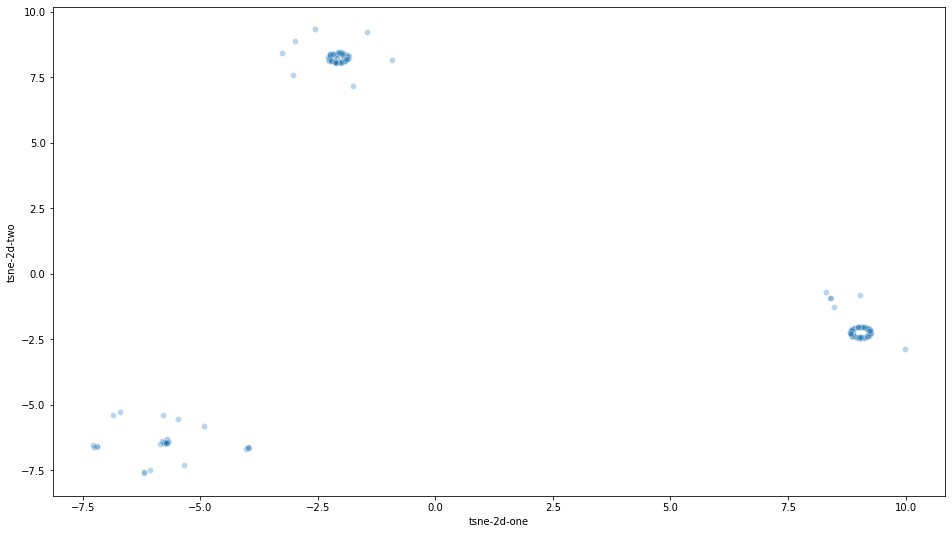

In [64]:
plt.rcParams["figure.figsize"] = (16,9)

plot_df = pd.DataFrame()
plot_df['tsne-2d-one'] = tsne_results[:,0]
plot_df['tsne-2d-two'] = tsne_results[:,1]
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=plot_df,
    legend="full",
    alpha=0.3
)

In [67]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(pivoted)

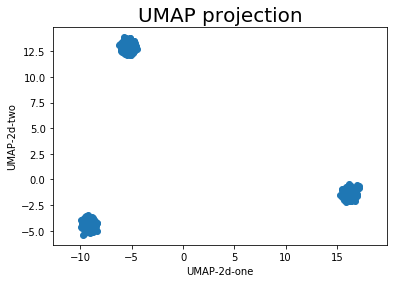

In [68]:
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.xlabel('UMAP-2d-one')
plt.ylabel('UMAP-2d-two')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=20);